<a href="https://colab.research.google.com/github/gabriellopes3/Ativos_Financeiros/blob/main/ativos_financeiros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
! pip install pandas_datareader
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np 
!pip install git+https://github.com/quantopian/pyfolio 
import pyfolio as pf
import requests
import json

yf.pdr_override()

In [3]:
''' Extraindo dados do Ibovespa da web (Fonte: Yahoo finance)'''

ibovespa = pdr.DataReader('^BVSP', data_source = 'yahoo')
display(ibovespa)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0
1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0
1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0
1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0
...,...,...,...,...,...,...
2021-05-20,122636.000000,122734.000000,122136.000000,122701.000000,122701.000000,7906400
2021-05-21,122701.000000,122799.000000,121760.000000,122592.000000,122592.000000,9493600
2021-05-24,122592.000000,124167.000000,122526.000000,124032.000000,124032.000000,8186300


Text(0.5, 1.0, 'Série histórica Ibovespa')

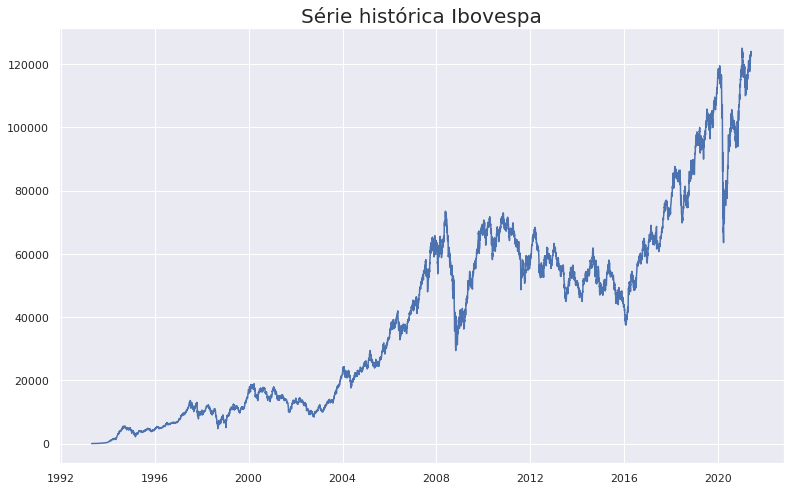

In [4]:
seaborn.set()
plt.figure(figsize = (13,8))
plt.plot(ibovespa['Close'])
plt.title('Série histórica Ibovespa', fontsize = 20)

[*********************100%***********************]  1 of 1 completed


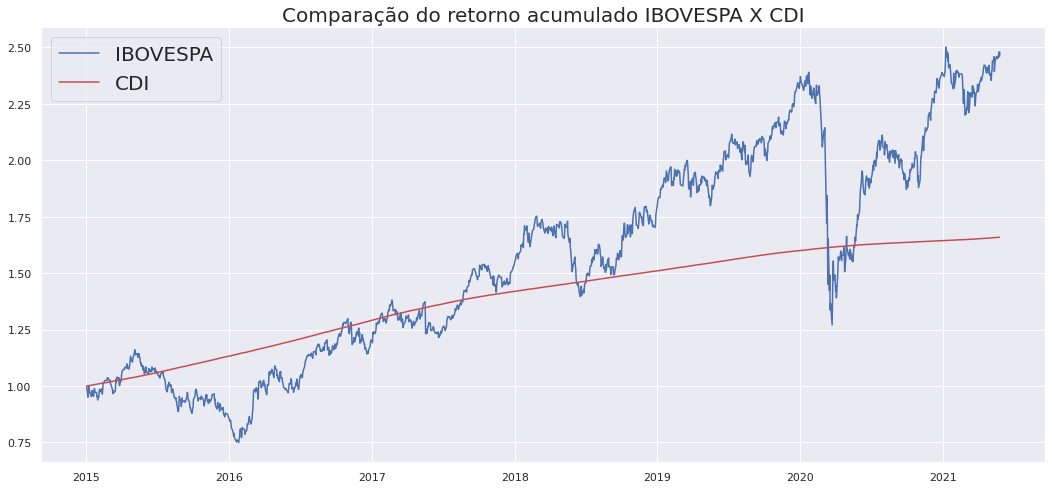

In [22]:
''' Utilizando a mesma lógica da célula acima para extrair dados do Ibovespa e usando 
a API do Banco Central para extrair dados do CDI diário, faremos uma comparação entre os dois'''

data_inicio = '2015-01-01'

ibov = yf.download(tickers='^BVSP')[['Close']]
ibov_retorno = ibov.pct_change()
ibov_retorno_acumulado = (1 + ibov_retorno[ibov_retorno.index >= data_inicio]).cumprod()
ibov_retorno_acumulado.iloc[0] = 1
# display(ibov_retorno_acumulado)

cdi = pd.read_json('http://api.bcb.gov.br/dados/serie/bcdata.sgs.12/dados?formato=json')
cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
cdi.set_index('data', inplace=True)
cdi_acumulado = (1 + cdi[cdi.index >= data_inicio] / 100).cumprod()
cdi_acumulado.iloc[0] = 1
# display(cdi_acumulado)

seaborn.set()
plt.figure(figsize = (18,8))
plt.title(label = "Comparação do retorno acumulado IBOVESPA X CDI", fontsize = 20)
plt.plot(ibov_retorno_acumulado['Close'], label = 'IBOVESPA')
plt.plot(cdi_acumulado['valor'], label = 'CDI', c = 'r')
plt.legend(fontsize = 20)

Iremos agora explanar o exemplo mais utilizado de correlação de ativos financeiros, o ibovespa e o dólar. Os dados serão extráidos pela web do yahoo finance, mas dessa vez será necessário fazer um tratamento dos dados, visto que, em um mesmo período, a quantidade de valores a serem comparados é diferente, pois há dias em que o ibovespa não se movimenta, mas o dólar sim (feriados, por exemplo). Para fazermos essa comparação, colocaremos os dados do ibovespa e do dólar em um mesmo DataFrame e eliminaremos as linhas onde existirão valores nulos (NaN).

In [6]:
ibov_dol = ['^BVSP', 'USDBRL=X']
id_df = pdr.get_data_yahoo(ibov_dol, start = '2006-01-01')['Close']
id_df = id_df.dropna()
id_df.columns = ['DÓLAR', 'IBOVESPA']
id_df['IBOV EM DÓLAR'] = id_df['IBOVESPA']/ id_df['DÓLAR']
display(id_df)

[*********************100%***********************]  2 of 2 completed


,DÓLAR,IBOVESPA,IBOV EM DÓLAR
Date,,,
2006-03-24,2.1547,37577.00000,17439.550419
2006-03-27,2.1503,37641.00000,17504.999091
2006-03-28,2.1677,36682.00000,16922.082906
2006-03-29,2.2206,37492.00000,16883.725958
2006-03-30,2.1922,37777.00000,17232.460971
...,...,...,...
2021-05-20,5.3080,122701.00000,23116.239256
2021-05-21,5.2813,122592.00000,23212.466329
2021-05-24,5.3618,124032.00000,23132.529284


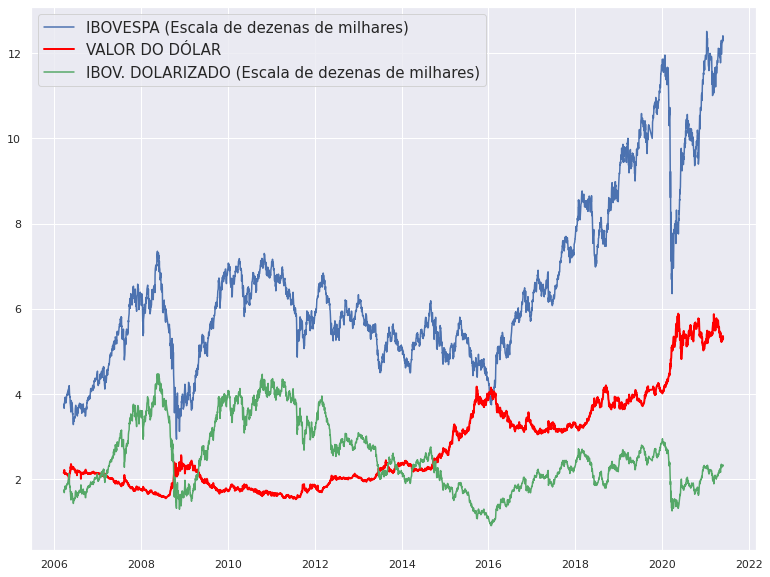

In [7]:
seaborn.set()
plt.figure(figsize = (13, 10))
plt.plot(id_df['IBOVESPA']/10000, label = 'IBOVESPA (Escala de dezenas de milhares)')
plt.plot(id_df.DÓLAR,lw =2, label = 'VALOR DO DÓLAR', c = 'red')
plt.plot(id_df['IBOV EM DÓLAR']/10000 , label = 'IBOV. DOLARIZADO (Escala de dezenas de milhares)', c = 'g')
plt.legend(fontsize = 15)

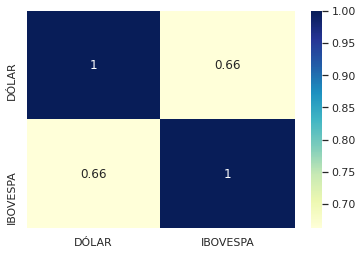

In [8]:
id_df_ = id_df.drop('IBOV EM DÓLAR', axis = 1)
seaborn.heatmap(id_df_.corr(), cmap ='YlGnBu', annot = True)

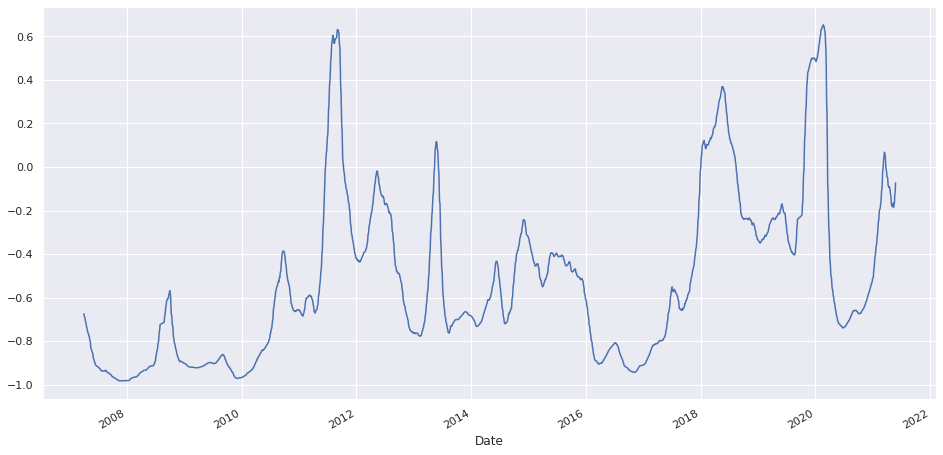

In [9]:
id_df['DÓLAR'].rolling(252).corr(id_df['IBOVESPA']).plot(figsize = (16,8)) # 252 é, aproximadamente,a quantidade dias úteis em um ano

Como podemos observar no gráfico acima, os valores chegaram a ser muito correlacionados negativamente (isto é, próximo a -1,0) durante o ano de 2008 e depois sofreu diversas variações, chegando a ficar positivamente correlacionado, mas nunca passando de 0,6.

Faremos agora um estudo da correlação entre as ações da petrobrás e a cotação do petróleo brent

In [10]:
petrobras_brent = ['PETR4.SA', 'BZ=F']
pp_df = pdr.get_data_yahoo(petrobras_brent)['Close']
pp_df = pp_df.dropna()
pp_df.columns = ['Cotação do petróleo Brent', 'Ações da Petrobrás']
display(pp_df)

[*********************100%***********************]  2 of 2 completed


,Cotação do petróleo Brent,Ações da Petrobrás
Date,,
2007-07-30,75.739998,26.799999
2007-07-31,77.050003,26.370001
2007-08-01,75.349998,26.450001
2007-08-02,75.760002,26.405001
2007-08-03,74.750000,25.200001
...,...,...
2021-05-20,65.110001,25.930000
2021-05-21,66.440002,25.950001
2021-05-24,68.459999,26.389999


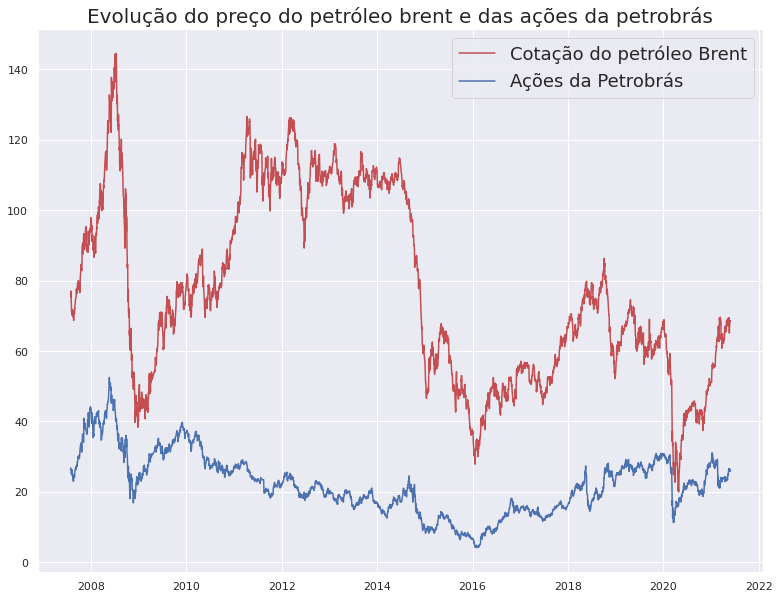

In [11]:
plt.figure(figsize = (13, 10))
plt.title('Evolução do preço do petróleo brent e das ações da petrobrás', fontsize = 20)
plt.plot(pp_df['Cotação do petróleo Brent'], label = 'Cotação do petróleo Brent', c = 'r')
plt.plot(pp_df['Ações da Petrobrás'], label = 'Ações da Petrobrás')
plt.legend(fontsize = 18)

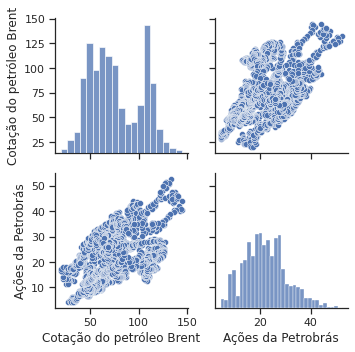

In [12]:
seaborn.set(style = 'ticks')
seaborn.pairplot(pp_df)

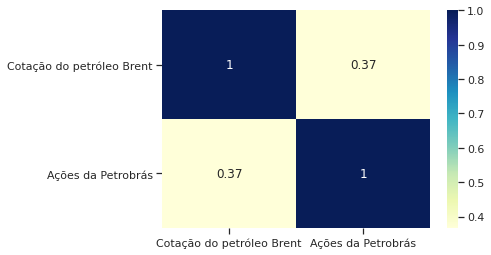

In [13]:
seaborn.heatmap(pp_df.corr(), cmap ='YlGnBu', annot = True)

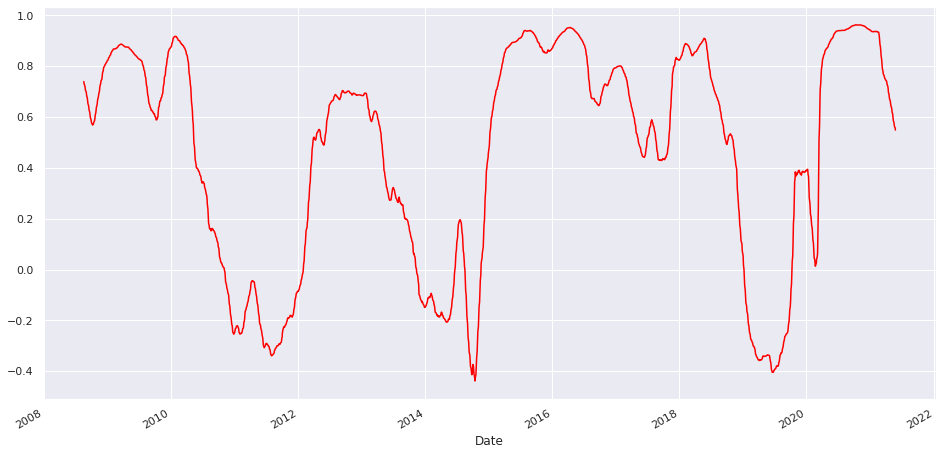

In [14]:
seaborn.set()
pp_df['Ações da Petrobrás'].rolling(252).corr(pp_df['Cotação do petróleo Brent']).plot(figsize = (16,8), c = 'red')

Com esse segundo exemplo de dois ativos que possuem uma ligação evidente (ações de um pretolífera e a cotação do barríl de petóleo) mas que, quando calculamos sua correlação, recebemos um valor abaixo do que seria "esperado" Isso se da pelo alto grau de volatilidade nos preços, ficando difícil averiguar matematicamente uma correlação, pois "Há fortes evidências de que os preços das ações, embora não sejam exatamente um passeio aleatório (random walk), estejam muito próximos disso" (Mankiw, p. 559)

In [15]:
''' Trabalhando com uma carteira de ações'''

acoes = ['VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'PETR4.SA']
carteira = pdr.get_data_yahoo(acoes, period = '8y')['Close']
carteira.dropna()
display(carteira)

x = ['^BVSP', '^IBX50']
ibov_ibrx = pdr.get_data_yahoo(x, period = '8y')['Close']
ibov_ibrx.dropna()
display(ibov_ibrx)

[*********************100%***********************]  5 of 5 completed


,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-27,16.752459,16.221569,16.398697,19.930000,31.850000
2013-05-28,16.978437,16.316433,16.453794,20.040001,31.299999
2013-05-29,16.624470,15.965439,16.053091,19.850000,31.049999
2013-05-31,16.408489,16.283230,16.218382,20.059999,30.450001
2013-06-03,16.034525,15.813658,16.088154,20.290001,31.600000
...,...,...,...,...,...
2021-05-20,17.540001,25.809999,29.290001,25.930000,111.110001
2021-05-21,17.610001,25.930000,29.430000,25.950001,109.400002
2021-05-24,17.629999,25.860001,29.350000,26.389999,109.779999


[*********************100%***********************]  2 of 2 completed


,^BVSP,^IBX50
Date,,
2013-05-27,56396.00000,8936.469727
2013-05-28,56036.00000,8949.169922
2013-05-29,54635.00000,8794.629883
2013-05-31,53506.00000,8742.509766
2013-06-03,53944.00000,8759.219727
...,...,...
2021-05-20,122701.00000,20625.929688
2021-05-21,122592.00000,20572.720703
2021-05-24,124032.00000,20762.480469


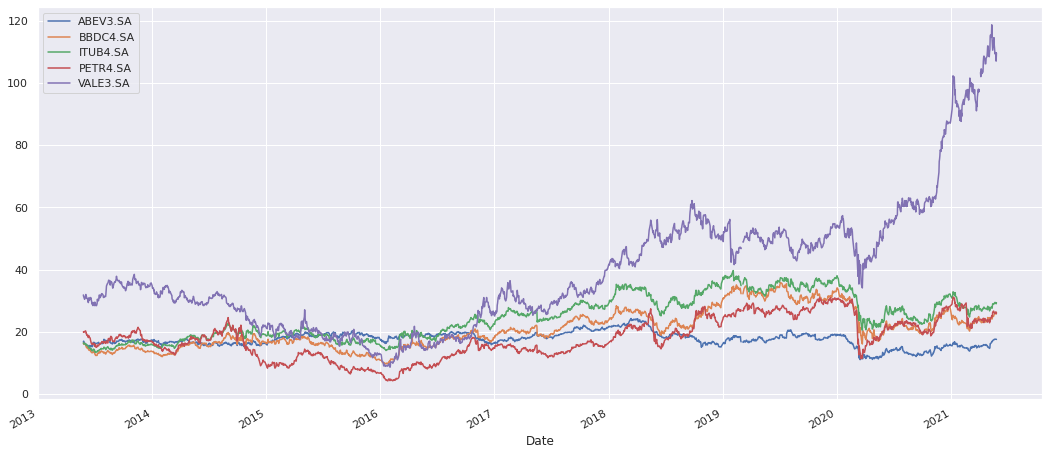

In [16]:
seaborn.set()
carteira.plot(figsize = (18,8))

A seguir, faremos um exemplo calculando o retorno e o desvio padrão desta mesma carteira. Depois, calcularemos o saldo desta carteira admitindo que um investidor comprou R$ 5.000,00 de cada uma destas ações, seguidamente iremos comparar os rendimentos dessa carteira com o ibovespa e o ibrx.

In [17]:
retorno = carteira.pct_change()
display(retorno)

retorno_acum = (retorno + 1).cumprod()
retorno_acum.iloc[0] = 1
display(retorno_acum)

,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-27,NaN,NaN,NaN,NaN,NaN
2013-05-28,0.013489,0.005848,0.003360,0.005519,-0.017268
2013-05-29,-0.020848,-0.021512,-0.024353,-0.009481,-0.007987
2013-05-31,-0.012992,0.019905,0.010297,0.010579,-0.019324
2013-06-03,-0.022791,-0.028838,-0.008030,0.011466,0.037767
...,...,...,...,...,...
2021-05-20,-0.001139,0.009386,0.005493,-0.008413,-0.010156
2021-05-21,0.003991,0.004649,0.004780,0.000771,-0.015390
2021-05-24,0.001136,-0.002700,-0.002718,0.016956,0.003473


,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-27,1.000000,1.000000,1.000000,1.000000,1.000000
2013-05-28,1.013489,1.005848,1.003360,1.005519,0.982732
2013-05-29,0.992360,0.984211,0.978925,0.995986,0.974882
2013-05-31,0.979468,1.003801,0.989004,1.006523,0.956044
2013-06-03,0.957145,0.974854,0.981063,1.018063,0.992151
...,...,...,...,...,...
2021-05-20,1.047011,1.591091,1.786118,1.301054,3.488540
2021-05-21,1.051189,1.598489,1.794655,1.302057,3.434851
2021-05-24,1.052383,1.594174,1.789776,1.324134,3.446782


In [18]:
''' Calculando o desvio Padrão (DP) de cada ação da carteira'''

dp = retorno.std()
print(dp)

ABEV3.SA    0.017025
BBDC4.SA    0.023472
ITUB4.SA    0.020848
PETR4.SA    0.033152
VALE3.SA    0.029210
dtype: float64


In [19]:
ex_carteira = (carteira / carteira.iloc[0]) * 5000
ex_carteira['SALDO'] = ex_carteira.sum(axis = 1)
ex_carteira = ex_carteira.loc[ex_carteira['SALDO'] > 0]
ex_carteira['RETORNO'] = ex_carteira['SALDO'].pct_change()
ex_carteira.dropna()
display(ex_carteira)
ex_ibov_ibrx = ibov_ibrx / ibov_ibrx.iloc[0] * 25000
display (ex_ibov_ibrx)

,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,SALDO,RETORNO
Date,,,,,,,
2013-05-27,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,25000.000000,NaN
2013-05-28,5067.446474,5029.240048,5016.799378,5027.596741,4913.657592,25054.740232,0.002190
2013-05-29,4961.799991,4921.052576,4894.623990,4979.929774,4874.411125,24631.817455,-0.016880
2013-05-31,4897.337652,5019.005796,4945.021541,5032.613938,4780.219843,24674.198770,0.001721
2013-06-03,4785.722898,4874.268852,4905.314714,5090.316258,4960.753533,24616.376255,-0.002343
...,...,...,...,...,...,...,...
2021-05-20,5235.052765,7955.457135,8930.587929,6505.268416,17442.700044,46069.066290,-0.002541
2021-05-21,5255.945130,7992.445184,8973.274061,6510.286093,17174.254351,45906.204819,-0.003535
2021-05-24,5261.913971,7970.869067,8948.881902,6620.672099,17233.908550,46036.245589,0.002833


,^BVSP,^IBX50
Date,,
2013-05-27,25000.000000,25000.000000
2013-05-28,24840.414214,25035.529117
2013-05-29,24219.359529,24603.199451
2013-05-31,23718.880772,24457.392105
2013-06-03,23913.043478,24504.138644
...,...,...
2021-05-20,54392.598766,57701.559784
2021-05-21,54344.279736,57552.706305
2021-05-24,54982.622881,58083.564047


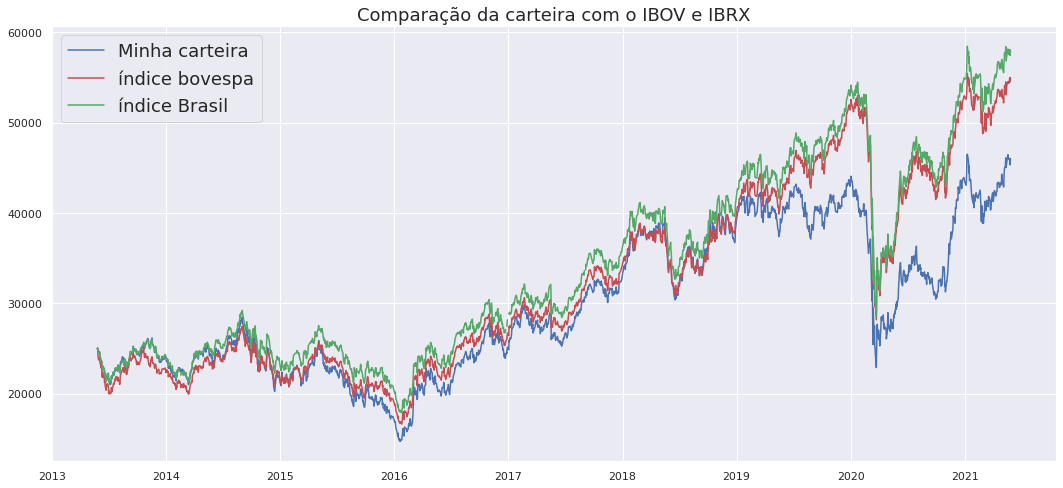

In [20]:
seaborn.set()
plt.figure(figsize = (18,8))
plt.title('Comparação da carteira com o IBOV e IBRX', fontsize = 18)
plt.plot(ex_carteira['SALDO'], label = 'Minha carteira')
plt.plot(ex_ibov_ibrx['^BVSP'], label = 'índice bovespa', color = 'r')
plt.plot(ex_ibov_ibrx['^IBX50'], label = 'índice Brasil', color = 'g')
plt.legend(fontsize = 18)
plt.show()

Start date,2013-05-27
End date,2021-05-26
Total months,94
,Backtest
Annual return,8.055%
Cumulative returns,83.971%
Annual volatility,29.179%
Sharpe ratio,0.41
Calmar ratio,0.17
Stability,0.64
Max drawdown,-48.35%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,48.35,2014-09-02,2016-01-21,2017-01-26,628
1,48.08,2020-01-02,2020-03-23,2021-01-06,265
2,23.03,2018-05-16,2018-06-18,2018-11-05,124
3,19.71,2013-11-18,2014-03-14,2014-07-21,176
4,16.47,2021-01-08,2021-02-26,NaT,NaN


Stress Events,mean,min,max
Apr14,0.10%,-2.54%,2.92%
Oct14,0.05%,-4.01%,6.74%
Fall2015,-0.15%,-3.16%,4.67%
New Normal,0.05%,-13.69%,15.89%


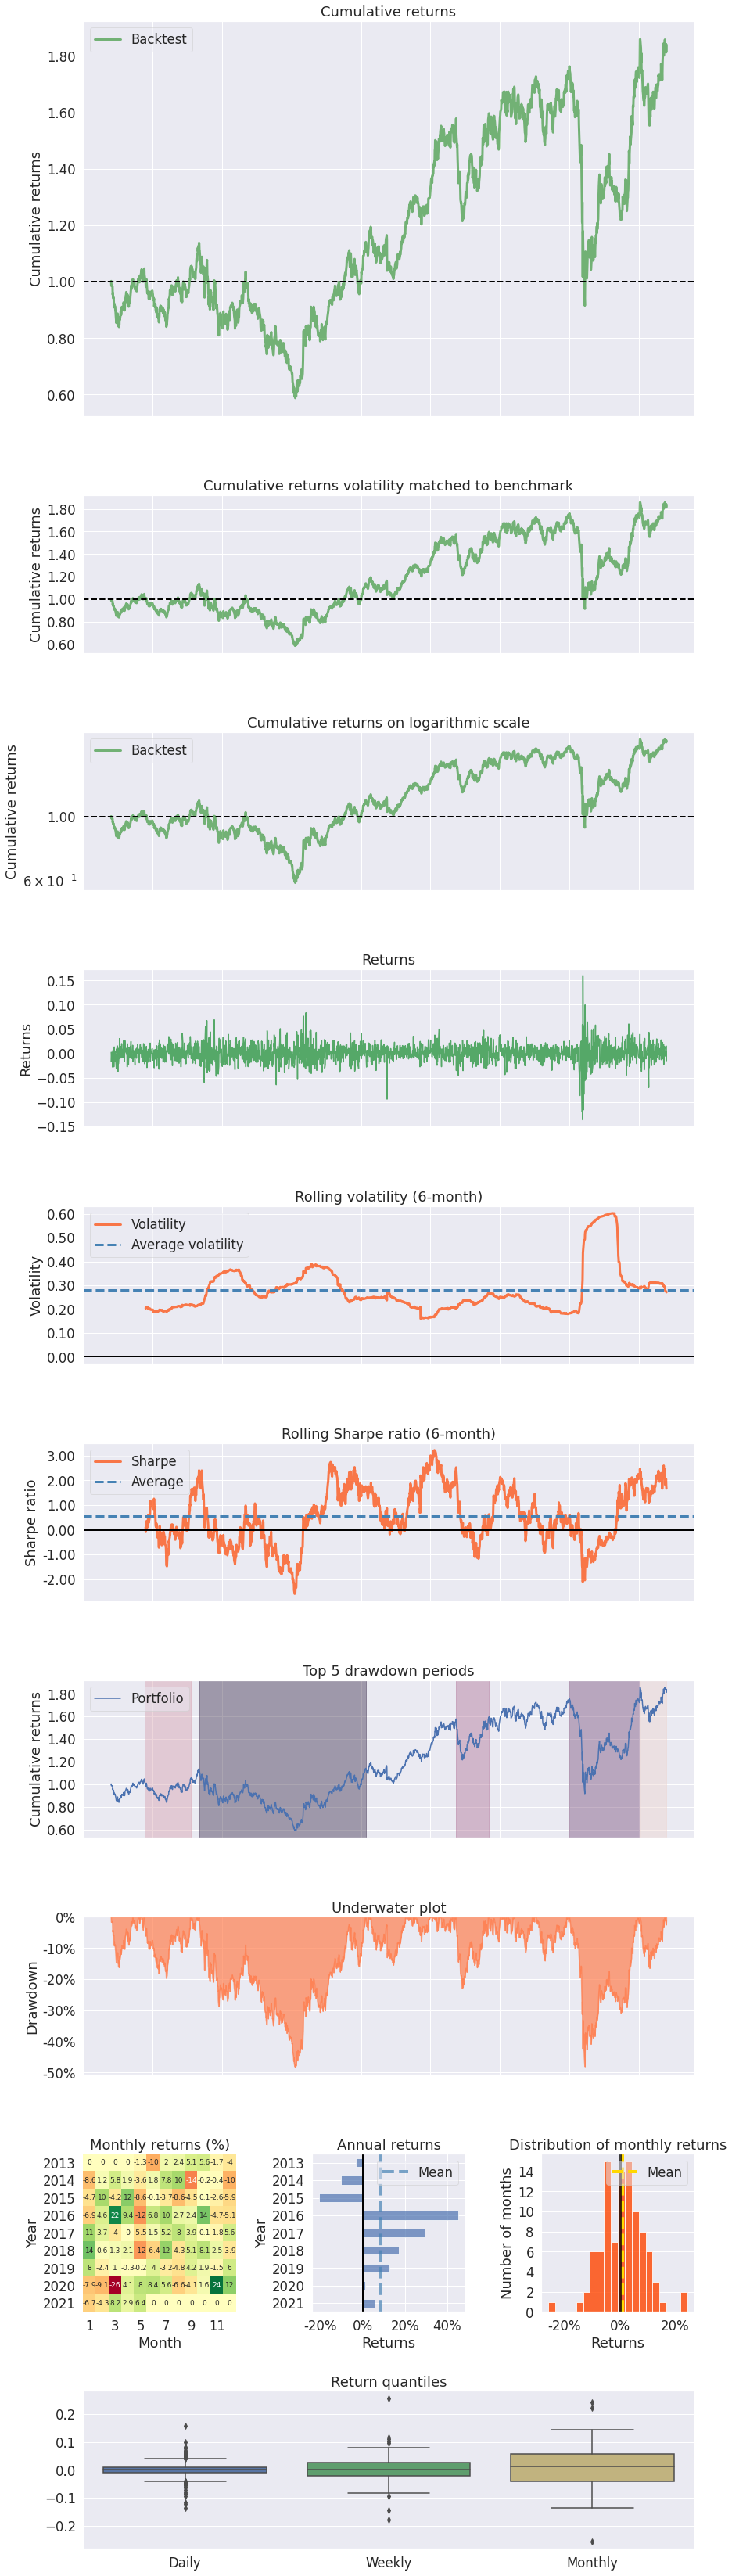

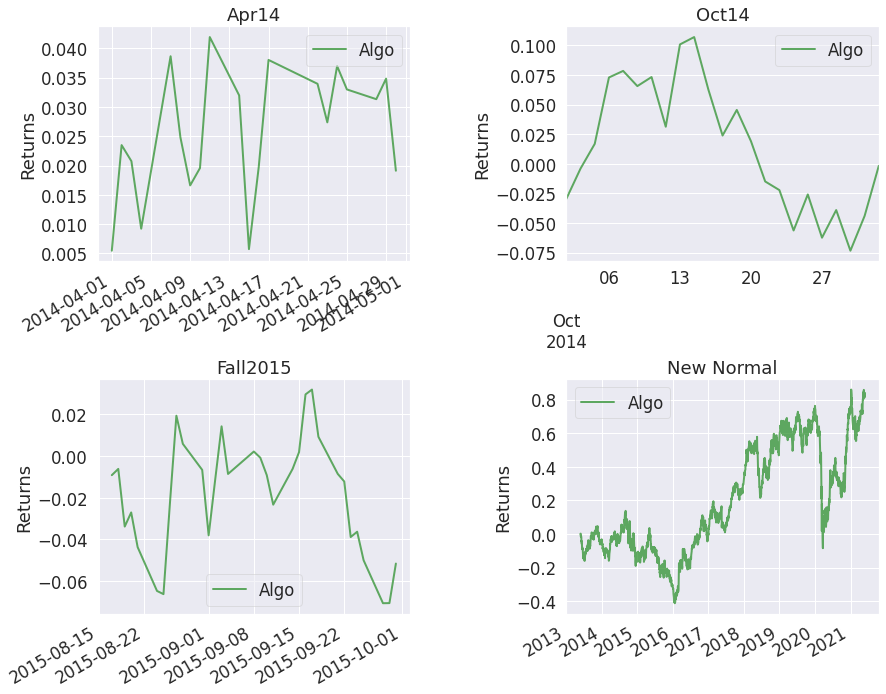

In [21]:
'' 'Backtesting da carteira com o pyfolio '''

pf.create_full_tear_sheet(ex_carteira['RETORNO'])